# Sentiment analyzer - finviz

In [8]:
import nltk
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to C:\Users\Aron
[nltk_data]     Gosch\AppData\Roaming\nltk_data...


True

In [9]:
import os
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup
import pandas as pd
from urllib.request import urlopen, Request
from nltk.sentiment.vader import SentimentIntensityAnalyzer

## 1) Data processing

In [2]:
url = 'https://finviz.com/quote.ashx?t=AMZN'

In [3]:
web_url = 'https://finviz.com/quote.ashx?t='

news_tables = {}
tickers = ['AMZN', 'GOOG', 'TSLA']

for tick in tickers:
    url = web_url + tick
    req = Request(url=url,headers={"User-Agent": "Chrome"}) 
    response = urlopen(req)    
    html = BeautifulSoup(response,"html.parser")
    news_table = html.find(id='news-table')
    news_tables[tick] = news_table

In [4]:
amazon = news_tables['AMZN']
amazon_tr = amazon.findAll('tr')

for x, table_row in enumerate(amazon_tr):
    a_text = table_row.a.text
    td_text = table_row.td.text
    print(a_text)
    print(td_text)
    if x == 3:
        break

Worried About the Market Correction? 3 Tech Stocks to Buy Right Now and Hold Forever
Feb-27-22 07:45AM  
UPDATE 2-India's Future Retail suspends supermarket operations as Reliance plans takeover
02:04AM  
India's Future Retail suspends supermarket operations as Reliance plans takeover
01:11AM  
Shopify Is Taking Its Delivery Services From Test Mode to All-Out Growth Mode
Feb-26-22 07:20AM  


In [5]:
news_list = []

for file_name, news_table in news_tables.items():
    for i in news_table.findAll('tr'):
        text = i.a.get_text() 
        date_scrape = i.td.text.split()

        if len(date_scrape) == 1:
            time = date_scrape[0]
        else:
            date = date_scrape[0]
            time = date_scrape[1]

        tick = file_name.split('_')[0]
        news_list.append([tick, date, time, text])

In [10]:
vader = SentimentIntensityAnalyzer()

columns = ['ticker', 'date', 'time', 'headline']
news_df = pd.DataFrame(news_list, columns=columns)
scores = news_df['headline'].apply(vader.polarity_scores).tolist()
scores_df = pd.DataFrame(scores)
news_df = news_df.join(scores_df, rsuffix='_right')
news_df['date'] = pd.to_datetime(news_df.date).dt.date

print(news_df.head())

  ticker        date     time  \
0   AMZN  2022-02-27  07:45AM   
1   AMZN  2022-02-27  02:04AM   
2   AMZN  2022-02-27  01:11AM   
3   AMZN  2022-02-26  07:20AM   
4   AMZN  2022-02-26  07:15AM   

                                            headline    neg    neu    pos  \
0  Worried About the Market Correction? 3 Tech St...  0.145  0.855  0.000   
1  UPDATE 2-India's Future Retail suspends superm...  0.000  1.000  0.000   
2  India's Future Retail suspends supermarket ope...  0.000  1.000  0.000   
3  Shopify Is Taking Its Delivery Services From T...  0.000  0.822  0.178   
4  The S&P 500 Index Just Entered Correction Terr...  0.000  0.893  0.107   

   compound  
0   -0.2960  
1    0.0000  
2    0.0000  
3    0.3818  
4    0.2023  


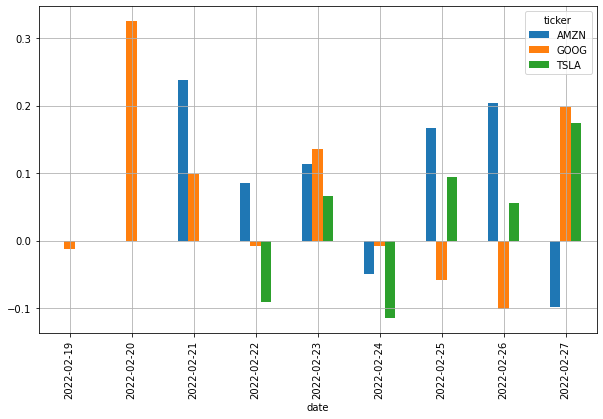

In [11]:
plt.rcParams['figure.figsize'] = [10, 6]
mean_scores = news_df.groupby(['ticker','date']).mean()
mean_scores = mean_scores.unstack()
mean_scores = mean_scores.xs('compound', axis="columns").transpose()
mean_scores.plot(kind = 'bar')

plt.grid()
plt.show()

## 2) Recommendations

In [13]:
mean_scores

ticker,AMZN,GOOG,TSLA
date,,,
2022-02-19,NaN,-0.012750,NaN
2022-02-20,NaN,0.325050,NaN
2022-02-21,0.237200,0.098382,NaN
2022-02-22,0.085879,-0.008508,-0.091067
2022-02-23,0.112932,0.135894,0.065842
2022-02-24,-0.049773,-0.008257,-0.114363
2022-02-25,0.166276,-0.059150,0.093464
2022-02-26,0.203233,-0.101083,0.055500
2022-02-27,-0.098667,0.198575,0.174475


In [14]:
# Positive compound means buy, negative sell (Good/bad buzz on a stock)
mean_scores.mean()

ticker
AMZN    0.093869
GOOG    0.063128
TSLA    0.030642
dtype: float64